In [1]:
# Import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

In [2]:
# Read the data
reports = pd.read_csv("scraped data for LDA/geopolitics2y.csv")
reports.head()
reports.info()

# Our spaCy model:
nlp = en_core_web_md.load()

# Tags we want to remove from the text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
tokens = []

reports['Description'] = reports['Description'].astype(str)
for description in nlp.pipe(reports['Description']):
   proj_tok = [token.lemma_.lower() for token in description if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   tokens.append(proj_tok)

# Add tokens to new column
reports['tokens'] = tokens
reports['tokens']

# Create dictionary
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(reports['tokens'])
print(dictionary.token2id)

# Filter dictionary
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

# Create corpus
corpus = [dictionary.doc2bow(doc) for doc in reports['tokens']]

# LDA model building
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 4, passes=10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4455 entries, 0 to 4454
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Time         4455 non-null   object
 1   Title        4455 non-null   object
 2   Description  4455 non-null   object
 3   Link         4455 non-null   object
 4   Datetime     4455 non-null   object
dtypes: object(5)
memory usage: 174.2+ KB
{'aide': 0, 'americans': 1, 'biden': 2, 'bill': 3, 'dour': 4, 'economy': 5, 'effort': 6, 'election': 7, 'joe': 8, 'lift': 9, 'major': 10, 'mood': 11, 'political': 12, 'president': 13, 'seek': 14, 'shore': 15, 'speech': 16, 'weakness': 17, 'wednesday': 18, 'work': 19, 'action': 20, 'announce': 21, 'block': 22, 'cancel': 23, 'condemn': 24, 'court': 25, 'debt': 26, 'friday': 27, 'loan': 28, 'new': 29, 'plan': 30, 'provide': 31, 'relief': 32, 'reuters': 33, 'ruling': 34, 'student': 35, 'supreme': 36, 'wake': 37, 'washington': 38, 'benefit': 39, 'campaign': 40, 'd

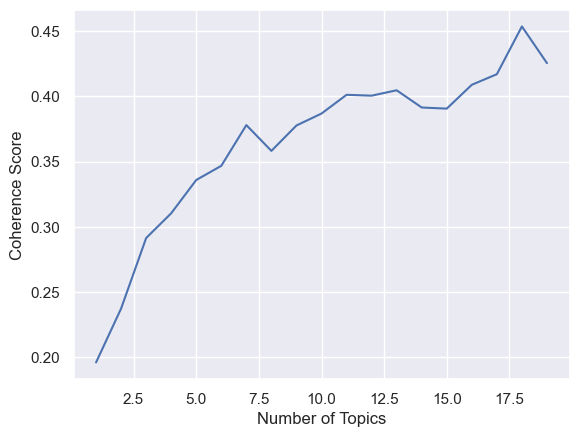

In [3]:
# Coherence score using C_v:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = reports['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [4]:
coherence_lda = cm.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.42554898065474045


In [13]:
# Optimal model
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=18, workers = 4, passes=100)

In [14]:
# Print topics
lda_model.print_topics(-1)

[(0,
  '0.077*"court" + 0.059*"supreme" + 0.048*"abortion" + 0.028*"right" + 0.023*"decision" + 0.020*"reuters" + 0.018*"justice" + 0.018*"state" + 0.016*"woman" + 0.014*"overturn"'),
 (1,
  '0.049*"united" + 0.043*"states" + 0.031*"say" + 0.027*"familiar" + 0.026*"biden" + 0.024*"source" + 0.022*"reuters" + 0.022*"washington" + 0.019*"matter" + 0.017*"president"'),
 (2,
  '0.039*"reuters" + 0.033*"washington" + 0.028*"gun" + 0.022*"senator" + 0.022*"thursday" + 0.021*"trade" + 0.018*"federal" + 0.018*"say" + 0.017*"wednesday" + 0.017*"lawmaker"'),
 (3,
  '0.034*"police" + 0.030*"man" + 0.028*"capitol" + 0.025*"reuters" + 0.023*"say" + 0.022*"year" + 0.018*"sentence" + 0.018*"charge" + 0.018*"washington" + 0.017*"attack"'),
 (4,
  '0.051*"department" + 0.046*"president" + 0.045*"justice" + 0.042*"trump" + 0.037*"donald" + 0.031*"document" + 0.024*"reuters" + 0.024*"washington" + 0.023*"fbi" + 0.021*"federal"'),
 (5,
  '0.049*"trump" + 0.047*"capitol" + 0.043*"committee" + 0.042*"donald

In [15]:
# Visualize topics
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

In [16]:
# Save the report
pyLDAvis.save_html(lda_display, 'saved html/geopolitics2y.html')

              x         y  topics  cluster      Freq
topic                                               
15     0.173211  0.066765       1        1  9.621138
16     0.095141  0.151929       2        1  7.887135
5     -0.090892  0.116499       3        1  7.739657
13     0.009833 -0.196865       4        1  6.910923
14    -0.234911  0.023024       5        1  6.537719
7      0.194900 -0.073399       6        1  6.468722
12     0.183445 -0.089185       7        1  6.188405
10    -0.060976 -0.203826       8        1  5.756262
6     -0.246936  0.043936       9        1  5.448713
0     -0.031287 -0.097449      10        1  5.295231
8      0.168345  0.056713      11        1  5.044963
4     -0.185306  0.140472      12        1  4.574950
2      0.108365 -0.057662      13        1  4.387552
1      0.100637  0.142020      14        1  4.259828
11     0.112335  0.126982      15        1  4.076980
17    -0.115469 -0.005254      16        1  3.934586
3     -0.102559 -0.010181      17        1  2.

Text(0, 0.5, 'Y Coordinate')

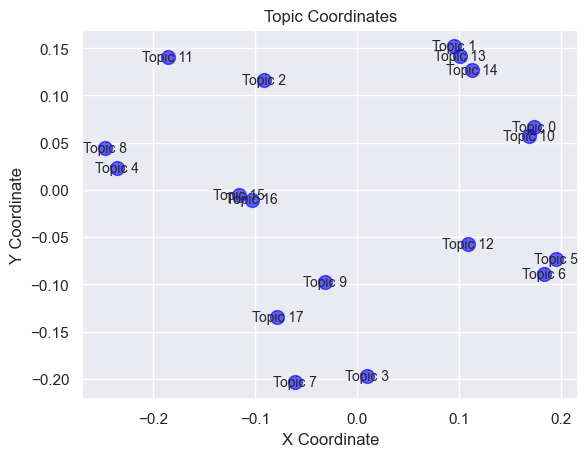

In [17]:
# Access the topic coordinates
topic_coordinates = lda_display.topic_coordinates

# Access the ordering of topics in the visualization
topic_order = lda_display.topic_order
print (topic_coordinates)

# Convert topic coordinates to NumPy array
topic_coordinates_array = topic_coordinates.values

# Create a scatter plot of the topic coordinates
plt.scatter(topic_coordinates_array[:, 0], topic_coordinates_array[:, 1], marker='o', c='blue', s=100, alpha=0.6)

# Add labels to the scatter plot
for topic, (x, y, *_) in enumerate(topic_coordinates_array):
    plt.text(x, y, f'Topic {topic}', fontsize=10, ha='center', va='center')

# Set plot title and axis labels
plt.title('Topic Coordinates')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

In [18]:
reports['topic'] = [sorted(lda_model[corpus][text])[0][0] for text in range(len(reports['Description']))]
reports.topic.value_counts()

topic
0     725
1     607
2     460
7     409
5     372
3     361
4     295
6     245
8     211
10    149
11    140
13    134
12    107
9      82
15     77
14     55
16     19
17      7
Name: count, dtype: int64

In [19]:
# Associate topics with datetime
reports['topic'] = [sorted(lda_model[corpus[text]], key=lambda x: x[1], reverse=True)[0][0] for text in range(len(reports['Description']))]
reports['topic'] = reports['topic'].astype(int)

# Merge topics with corresponding datetime
topics = lda_model.print_topics(num_topics=18, num_words=5)
topics_dict = {topic[0]: topic[1] for topic in topics}
reports['topic_words'] = reports['topic'].map(topics_dict)

# Resulting DataFrame with topics associated with datetime
print(reports[['Datetime', 'topic', 'topic_words']])

                       Datetime  topic   
0     2023-06-30 20:53:00+00:00     15  \
1     2023-06-30 20:31:00+00:00      0   
2     2023-06-30 20:26:00+00:00      0   
3     2023-06-30 19:21:00+00:00      0   
4     2023-06-30 18:50:00+00:00     17   
...                         ...    ...   
4450  2021-07-01 17:10:00+00:00      5   
4451  2021-07-01 16:44:00+00:00     16   
4452  2021-07-01 12:30:00+00:00     17   
4453  2021-07-01 09:11:00+00:00      6   
4454  2021-07-01 03:13:00+00:00     16   

                                            topic_words  
0     0.079*"joe" + 0.075*"biden" + 0.063*"president...  
1     0.077*"court" + 0.059*"supreme" + 0.048*"abort...  
2     0.077*"court" + 0.059*"supreme" + 0.048*"abort...  
3     0.077*"court" + 0.059*"supreme" + 0.048*"abort...  
4     0.051*"governor" + 0.047*"republican" + 0.043*...  
...                                                 ...  
4450  0.049*"trump" + 0.047*"capitol" + 0.043*"commi...  
4451  0.061*"biden" + 0.057*"pr

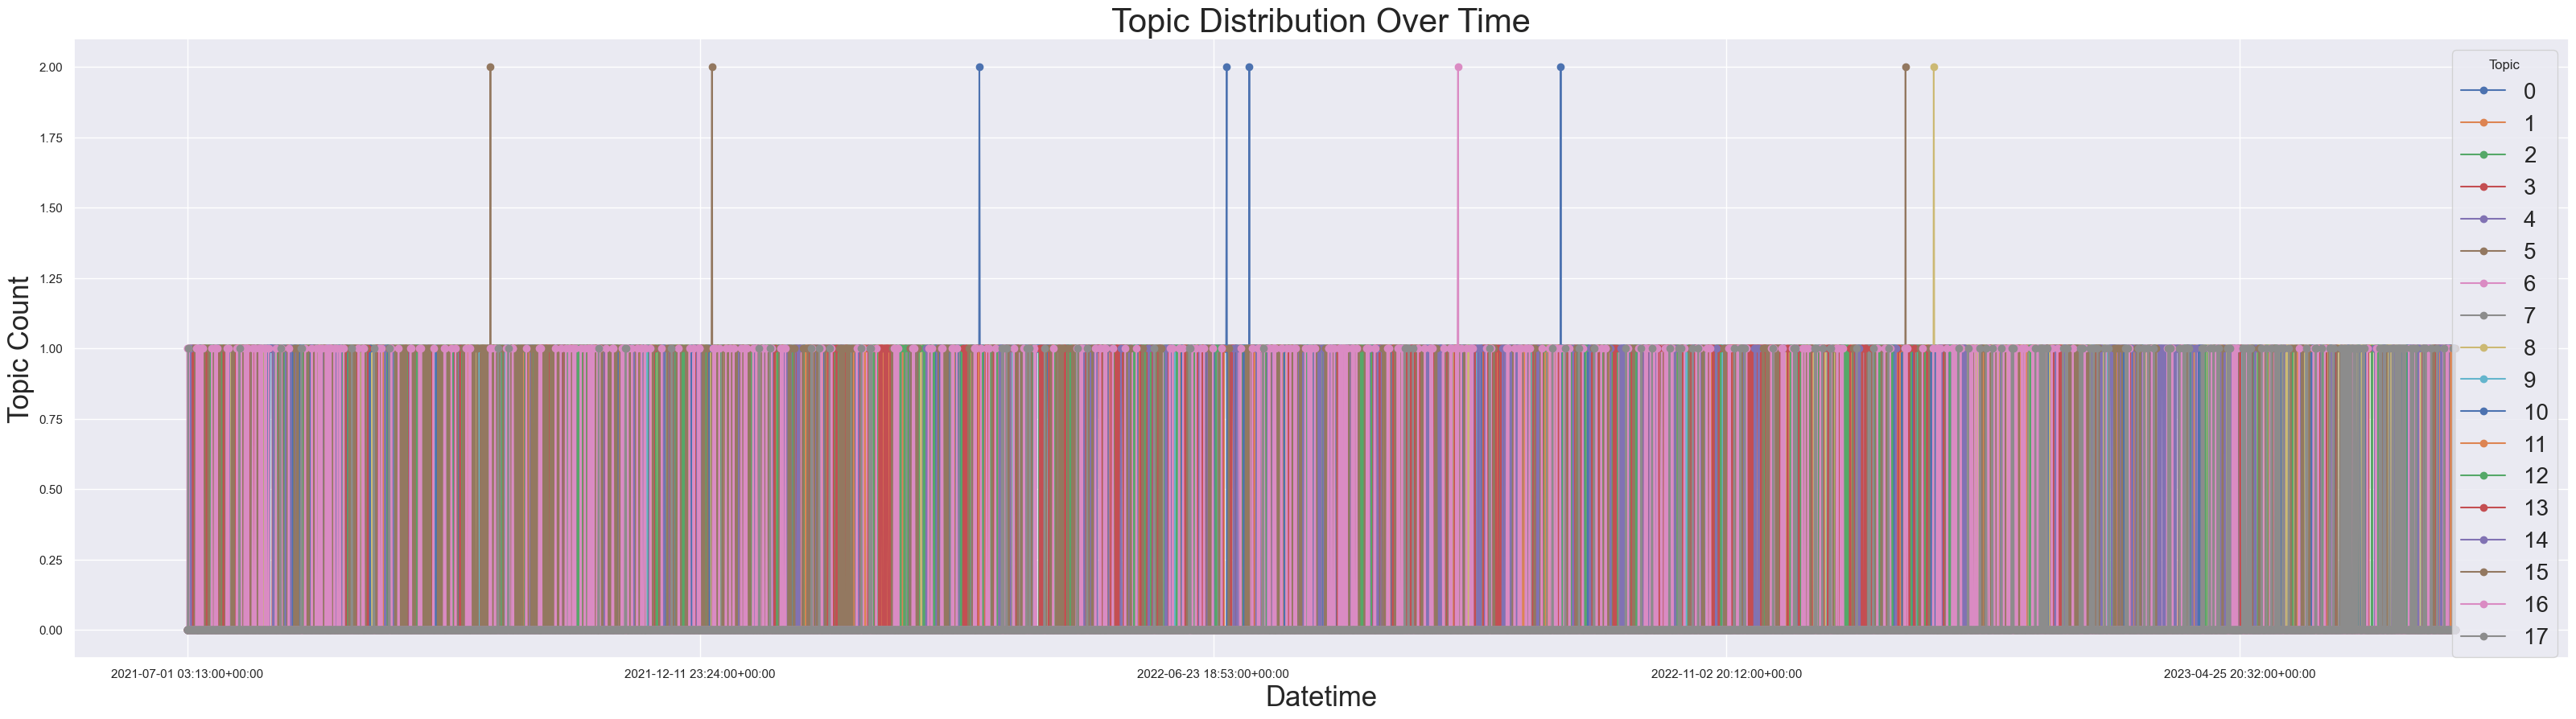

In [20]:
# Group the data by datetime and topic
grouped_data = reports.groupby(['Datetime', 'topic']).size().unstack().fillna(0)

# Plotting the distribution of topics over time
grouped_data.plot(kind='line', figsize=(40, 10), marker='o')

# Customize the plot
plt.title('Topic Distribution Over Time', fontsize=30)
plt.xlabel('Datetime', fontsize=25)
plt.ylabel('Topic Count', fontsize=25)
plt.legend(title='Topic', loc='upper right', fontsize=20)

# Show the plot
plt.show()